<a href="https://colab.research.google.com/github/Buchi1996/Comparing-Accuracy-rate-of-Classification-Algorithms-in-Sentiment-Analysis/blob/main/Models_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
#import pandas as pd    # to load dataset
#import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
#import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Bi_df = pd.read_csv ('Bfile0.csv')
#Tr_df = pd.read_csv ('Tfile1.csv')
Bi_df.head()

FileNotFoundError: ignored

In [ ]:
D = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/IMDB Dataset.csv")

In [ ]:
D.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Load and Clean Dataset**

In [ ]:
def load_dataset():
    D_df = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/IMDB Dataset.csv")
    x_data = D_df['review']       # Reviews/Input
    y_data = D_df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


Split Dataset(IMDB)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
42883    [i, find, movie, best, movie, i, ever, seen, r...
30590    [it, shame, movie, hard, get, hands, us, i, fo...
13472    [i, heard, read, many, praising, things, midni...
43517    [the, film, severely, awful, demeaning, rape, ...
47701    [this, absolutely, spellbinding, series, sorry...
                               ...                        
46676    [the, consequences, love, there, really, somet...
19393    [this, movie, terrible, john, wayne, brutal, a...
11732    [first, i, would, like, point, film, absolutel...
45799    [first, foremost, i, wish, aim, big, mean, mid...
32040    [solid, comedy, entertainment, musical, interl...
Name: review, Length: 40000, dtype: object 

30585    [maybe, excessive, weight, gain, seagal, put, ...
8189     [fr, ulein, doktor, good, demonstration, great...
17452    [essentially, story, man, versus, nature, film...
8907     [this, film, antonioni, middle, period, critic...
42438    [soultaker, written, starred, vivian, schillin...
 

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

**Tokenize and Pad/Truncate Reviews**

A Neural Network only accepts numeric data, so we need to encode the reviews. Use tensorflow.keras.-preprocessing.text.Tokenizer to encode the reviews into integers, where each unique word is automatically indexed (using fit_on_texts method) based on x_train. x_train and x_test is converted into integers using texts_to_sequences method.

Each reviews has a different length, so we need to add padding (by adding 0) or truncating the words to the same length (in this case, it is the mean of all reviews length) using tensorflow.keras.preprocessing.sequence.pad_sequences.

Post, pad or truncate the words in the back of a sentence; pre, pad or truncate the words in front of a sentence.

In [ ]:
print(x_train)
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

42883    [i, find, movie, best, movie, i, ever, seen, r...
30590    [it, shame, movie, hard, get, hands, us, i, fo...
13472    [i, heard, read, many, praising, things, midni...
43517    [the, film, severely, awful, demeaning, rape, ...
47701    [this, absolutely, spellbinding, series, sorry...
                               ...                        
46676    [the, consequences, love, there, really, somet...
19393    [this, movie, terrible, john, wayne, brutal, a...
11732    [first, i, would, like, point, film, absolutel...
45799    [first, foremost, i, wish, aim, big, mean, mid...
32040    [solid, comedy, entertainment, musical, interl...
Name: review, Length: 40000, dtype: object
Encoded X Train
 [[   1   79    3 ...    0    0    0]
 [   7  783    3 ... 2249  875   55]
 [   1  459  244 ... 8202 4153 3683]
 ...
 [  23    1   12 ...   46   67   51]
 [  23 6687    1 ...  265 1146   35]
 [1099  108  611 ...    0    0    0]] 

Encoded X Test
 [[  180  5096  3203 ...     0     0     0]
 [

**Build Architecture/Model**
Embedding Layer: in simple terms, it creates word vectors of each word in the word_index and group words that are related or have similar meaning by analyzing other words around them.

LSTM Layer: to make a decision to keep or throw away data by considering the current input, previous output, and previous memory. There are some important components in LSTM.

Forget Gate, decides information is to be kept or thrown away
Input Gate, updates cell state by passing previous output and current input into sigmoid activation function
Cell State, calculate new cell state, it is multiplied by forget vector (drop value if multiplied by a near 0), add it with the output from input gate to update the cell state value.
Ouput Gate, decides the next hidden state and used for predictions
Dense Layer: compute the input with the weight matrix and bias (optional), and using an activation function. I use Sigmoid activation function for this work because the output is only 0 or 1.

The optimizer is Adam and the loss function is Binary Crossentropy because again the output is only 0 and 1, which is a binary number.

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding


Tanh Fnction (Hyperbolic tangent activation function.)

In [ ]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model0 = Sequential()
model0.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model0.add(LSTM(LSTM_OUT))
#model0.add(Dense(64, activation='relu'))
model0.add(Dense(12, input_shape=(8,), activation='tanh'))
model0.add(Dense(8, activation='tanh'))
model0.add(Dense(1, activation='sigmoid'))
model0.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
plot_model(model0, to_file= "/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/modelLSTM.png")
print(model0.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2955456   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,981,181
Trainable params: 2,981,181
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/LSTM_2.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model0.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.5306 - accuracy: 0.6989
Epoch 00001: accuracy improved from -inf to 0.69888, saving model to /content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/LSTM_2.h5
313/313 [==============================] - 48s 145ms/step - loss: 0.5306 - accuracy: 0.6989
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9135
Epoch 00002: accuracy improved from 0.69888 to 0.91347, saving model to /content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/LSTM_2.h5
313/313 [==============================] - 44s 141ms/step - loss: 0.2336 - accuracy: 0.9135
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9580
Epoch 00003: accuracy improved from 0.91347 to 0.95802, saving model to /content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/LSTM/LSTM_2.h5
313/313 [=========

TESTING the LSTM Model

To evaluate the model, we need to predict the sentiment using our x_test data and comparing the predictions with y_test (expected output) data. Then, we calculate the accuracy of the model by dividing numbers of correct prediction with the total data.

In [ ]:
#y_pred = model.predict_classes(x_test, batch_size = 128)
y_pred=model0.predict(x_test) 
y_pred = np.round(y_pred).astype(int)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

Correct Prediction: 8687
Wrong Prediction: 1313
Accuracy: 86.87


In [ ]:
print(classification_report(y_test,y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.84      0.87      5029
           1       0.85      0.90      0.87      4971

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



array([[4219,  810],
       [ 503, 4468]])

Load Saved Model

Load saved model and use it to predict a movie review statement's sentiment (positive or negative)

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/MASTERS FOLDER/CS855/LSTM-Data/LSTM/LSTM.h5')

**Random Forest Classifier**

In [ ]:
#Feature scaling to scale the data or commonly known as normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
xtrain1 = scaler.transform(x_train)
xtest1 = scaler.transform(x_test)

In [ ]:
#Implementing Random Forest Algorithm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300, criterion="entropy")
rf.fit(xtrain1, y_train)
y_pred_RF = rf.predict(xtest1)

# Making Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
confusion_matrix(y_test, y_pred_RF)

array([[2945, 2084],
       [2328, 2643]])

In [ ]:
#Calculating Precision, Recall, F1-score, and Accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred_RF))
print(accuracy_score(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.56      0.59      0.57      5029
           1       0.56      0.53      0.55      4971

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000

0.5588


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Enable the classification function for KNN
knn = KNeighborsClassifier (n_neighbors=4)

# Enter training data in the classification function for KNN
knn.fit(x_train,y_train)

#Determine predictions or forecasts
y_pred_KNN = knn.predict(x_test)
y_pred_KNN= pd.DataFrame(y_pred_KNN)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Displays the prediction result matrix
print(confusion_matrix(y_test,y_pred_KNN))

[[3669 1360]
 [3511 1460]]


In [ ]:
#measure the accuracy or accuracy of the prediction results
print(classification_report(y_test,y_pred_KNN))
print(accuracy_score(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       0.51      0.73      0.60      5029
           1       0.52      0.29      0.37      4971

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.49     10000
weighted avg       0.51      0.51      0.49     10000

0.5129


**Testing on Tweet Data**

In [ ]:
Bide_df = pd.read_csv('/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/cleaned_sample_100_biden.csv')
Tru_df = pd.read_csv('/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/cleaned_sample_100_trump.csv')

In [ ]:
Bide_df.loc[:,'who'] = 'biden'
Tru_df.loc[:,'who'] = 'trump'

balance_data_df = pd.DataFrame(columns=Tru_df.columns)
balance_data_df

,tweet,long,lat,state_code,sentiment,who


In [ ]:
states_list = set(Bide_df['state_code']).union(set(Tru_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])

In [ ]:
for state in states_list:
    Tru_df_state = Tru_df[Tru_df['state_code']==state]
    Bide_df_state = Bide_df[Bide_df['state_code']==state]
    
    n_sample = len(Tru_df_state) if len(Tru_df_state) < len(Bide_df_state) else len(Bide_df_state)
    
    if len(Bide_df_state) < len(Bide_df_state):
        balance_data_df = pd.concat([balance_data_df, Tru_df_state])
        balance_data_df = pd.concat([balance_data_df, Bide_df_state.sample(len(Tru_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, Bide_df_state])
        #balance_data_df = pd.concat([balance_data_df, Tru_df_state.sample(len(Bide_df_state))])

In [ ]:
balance_data_df

,tweet,long,lat,state_code,sentiment,who
604,Hey Trump... NO MORE YEARS!!! realDonaldTrump...,-72.500261,44.599072,VT,0,biden
1485,"Yes, JoeBiden, I would like a fair shot, too. ...",-73.064280,43.876452,VT,0,biden
2706,Joe Biden was more decisive than you think .CN...,-72.603405,44.210076,VT,0,biden
4022,realDonaldTrump BreitbartNews This is the stuf...,-73.212906,44.476160,VT,0,biden
5217,My thumb hurts from liking all your celebrator...,-72.500261,44.599072,VT,0,biden
...,...,...,...,...,...,...
48373,What stage is Trump and his closest followers ...,-106.650985,35.084103,NM,0,biden
48556,"At times like these, it's best to say ""that go...",-106.650985,35.084103,NM,0,biden
48570,Seriously what are the odds JoeBiden makes it ...,-105.993007,34.570817,NM,0,biden
48716,KamalaHarris is our first female Vice Preside...,-105.993007,34.570817,NM,0,biden


In [ ]:
batch_size = 100

In [ ]:
from tqdm.auto import tqdm
import tensorflow as tf

def emotion_classify(tweet_list):
    batch_idx = np.append(np.arange(0, len(tweet_list), batch_size), len(tweet_list))
    labels = np.array([])
    for i in tqdm(range(len(batch_idx)-1)):
        tf_batch = tokenizer(tweet_list[batch_idx[i]:batch_idx[i+1]], max_length=280, padding=True, truncation=True, return_tensors='tf')
        tf_outputs = model(tf_batch)
        tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
        labels = np.append(labels, tf.argmax(tf_predictions, axis=1))
#         labels = np.append(labels, tf_predictions[:,1])
        del tf_batch
    return labels

In [ ]:
dem_states = set(['DC', 'VT', 'HI', 'MA', 'MD', 'CA', 'NY', 'RI', 'DE', 
                 'CT', 'WA', 'ME', 'NJ', 'OR', 'IL'])
rep_states = set(['OH', 'IA', 'TX', 'MT', 'SC', 'AK', 'MO', 'IN', 'NE',
                 'KS', 'UT', 'MS', 'TN', 'SD', 'KY', 'LA', 'AL', 'ND',
                 'ID', 'AR', 'OK', 'WV', 'WY'])
swing_states = states_list - dem_states - rep_states

In [ ]:
electoral_vote_by_state = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/electoral_vote_by_state.csv")


In [ ]:
states_results = pd.DataFrame(columns=['state_code', 'biden', 'trump', 'type', 'winner'])

In [ ]:
states_results.loc[:,'state_code'] = electoral_vote_by_state['state_code']
states_results.loc[:,'e_vote'] = electoral_vote_by_state['e_vote']

In [ ]:
type_vs_candidate = {'blue': 'biden', 'red': 'trump', 'purple': 'contentious'}
threshold = 1.15
for state in states_list:
    trump_slice = balance_data_df.query(f'state_code == "{state}" and who == "trump"')
    biden_slice = balance_data_df.query(f'state_code == "{state}" and who == "biden"')
    trump_score = np.sum(trump_slice['sentiment']) + 1
    biden_score = np.sum(biden_slice['sentiment']) + 1
    
    state_type = ''
    if state in dem_states:
        state_type = 'blue'
    elif state in rep_states:
        state_type = 'red'
    else:
        state_type = 'purple'
        
    winner = ''
    if len(trump_slice) + len(biden_slice) < 1000:
        winner = type_vs_candidate[state_type]
    else:
        if trump_score/biden_score > threshold:
            winner = 'trump'
        elif biden_score/trump_score > threshold:
            winner = 'biden'
        else:
            winner = 'contentious'
        
    states_results.loc[states_results['state_code'] == state, ['biden', 'trump', 'type', 'winner']] = \
        [biden_score, trump_score, state_type, winner]

In [ ]:
states_results.query('winner=="contentious"')

,state_code,biden,trump,type,winner,e_vote
4,AZ,1,1,purple,contentious,11
5,NV,1,1,purple,contentious,6
7,NH,1,1,purple,contentious,4
8,CA,1,1,blue,contentious,55
9,NJ,1,1,blue,contentious,14
10,CO,1,1,purple,contentious,9
11,NM,1,1,purple,contentious,5
13,NY,1,1,blue,contentious,29
15,NC,1,1,purple,contentious,15
16,DC,1,1,blue,contentious,3


In [ ]:
import itertools

In [ ]:
states_results = pd.read_csv('/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/state_results_100_conti.csv')

In [ ]:
contentious_states = states_results.loc[states_results['winner'] == 'contentious',['state_code', 'e_vote']]
contentious_states

,state_code,e_vote
0,AL,9
4,AZ,11
5,NV,6
7,NH,4
8,CA,55
9,NJ,14
10,CO,9
11,NM,5
12,CT,7
13,NY,29


In [ ]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

In [ ]:
num_vote_to_win = 270
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

41 14


In [ ]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt

us_shape = gpd.read_file('/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/us_shape/cb_2018_us_state_20m.shp')
us_shape = us_shape[['STUSPS', 'geometry']]
states_results_tmp = states_results.copy()
states_results_tmp = states_results_tmp.merge(us_shape, left_on='state_code', right_on='STUSPS')
states_results_tmp.drop(['STUSPS'], axis=1, inplace=True)
states_results_tmp = gpd.GeoDataFrame(states_results_tmp)

states_results_tmp.columns

Index(['state_code', 'biden', 'trump', 'type', 'winner', 'e_vote', 'geometry'], dtype='object')

[]

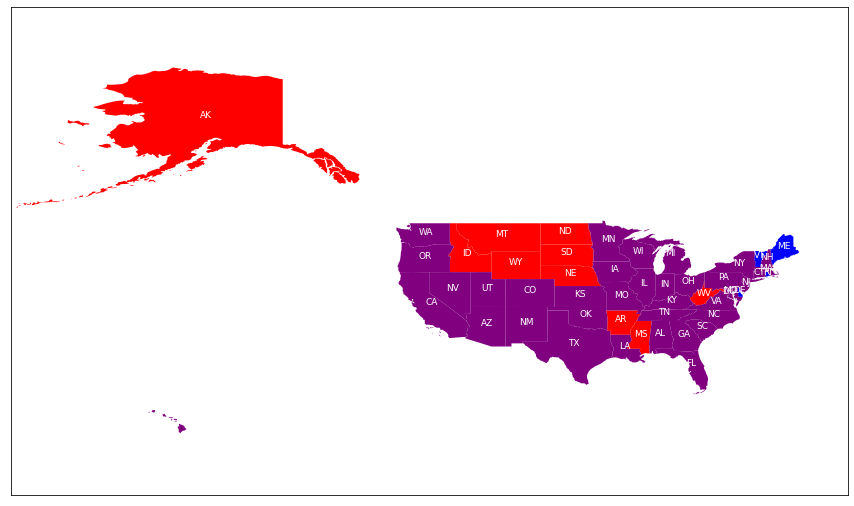

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
states_results_tmp.apply(lambda x: ax.annotate(s=x.state_code, xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, color='white'),axis=1);
states_results_tmp[states_results_tmp['winner'] == 'trump'].plot(ax=ax, color='red')
states_results_tmp[states_results_tmp['winner'] == 'biden'].plot(ax=ax, color='blue')
states_results_tmp[states_results_tmp['winner'] == 'contentious'].plot(ax=ax, color='purple')
plt.axis('square')
ax.set_xlim([-180, -60])
ax.set_ylim([10, 80])
ax.set_xticks([])
ax.set_yticks([])